# H3K4Me3 occupancy in immune cells via ChIP-seq

First, load file metadata and dependencies. Note that rows in the metadata are already aligned to be from the same observation.

In [2]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
from settings import settings, paths
import os
import muffin
import scanpy as sc

metadata_chip = pd.read_csv(paths.immuneChipPath + "metadata_mod.tsv", sep="\t")
# List of paths to all files
bam_files = [paths.immuneChipPath + "chip/" + f + ".bam" for f in metadata_chip.loc[:, "ChIP"]]
input_files = [paths.immuneChipPath + "input/" + f + ".bam" for f in metadata_chip.loc[:, "Inputs"]]
peak_files = [paths.immuneChipPath + "peaks/" + f + ".bigBed" for f in metadata_chip.loc[:, "Peaks"]]

Now, we load the bed files for each experiment. Here they were in bigBed format so that takes a bit more code.

In [3]:
import pyBigWig
def read_bigBed_encode(path):
    bb = pyBigWig.open(path)
    chroms = bb.chroms()
    entries_list = []
    for chrom, length in chroms.items():
        entries = bb.entries(chrom, 0, length)
        for entry in entries:
            entries_list.append({
                'chrom': chrom,
                'start': int(entry[0]),
                'end': int(entry[1]),
                'name': entry[2],
            })
    df = pd.DataFrame(entries_list)
    df[["name", "Score", "Strand", "FC", "Pval", "FDR", "Summit"]] = df["name"].str.split("\t", expand=True)
    df[["FC", "Pval", "FDR"]] = df[["FC", "Pval", "FDR"]].astype("float")
    df["Summit"] = df["Summit"].astype(int)
    return df
beds = [read_bigBed_encode(f) for f in peak_files]
# Not necessary
concat_bed = pd.concat(beds)
concat_bed.to_csv("h3k4me3_results/all_beds.bed",sep="\t",header=None,index=None)

Next, we will identify consensus peaks which merges similar peaks across experiments.

In [4]:
chromSizes = pd.read_csv(paths.chromsizes, sep="\t", header=None, index_col=0).iloc[:,0].to_dict()
consensus_peaks = muffin.merge_peaks(beds, chromSizes)
consensus_peaks.to_csv("h3k4me3_results/consensus_peaks.bed",sep="\t",header=None,index=None)
# Not needed anymore
del beds

Now that we have our genomic regions of interest, we can sample the sequencing signal in BAM files and generate the count matrix. Note that you can provide custom parameters for featureCounts here. Alternatively, instead of providing a dataframe for the query regions, you can provide a path to a bed or SAF file through the genomic_regions_path argument.

In [5]:
featureCountParams = {"nthreads":16, "allowMultiOverlap":True, "minOverlap":-100,
                      "countMultiMappingReads":False}
dataset = muffin.load.dataset_from_bam(bam_files, genomic_regions=consensus_peaks,
                                       input_bam_paths=input_files, 
                                       featureCounts_params=featureCountParams,chromsizes=chromSizes)

Directory tmp_muffin/ already exists !

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.8.2

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 52 BAM files                                     ||
||                                                                            ||
||                           ENCFF499NSJ.bam                                  ||
||                           ENCFF006DTI.bam                                  ||
||            

The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms.

In [6]:
print(dataset)

AnnData object with n_obs × n_vars = 52 × 163624
    var: 'Chromosome', 'Start', 'End', 'Strand'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    layers: 'input'


You can set plot settings for muffin :

In [7]:
muffin.params["autosave_plots"] = "h3k4me3_results/"
muffin.params["figure_dpi"] = 300
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=300, dpi_save=300)
sc.settings.autosave = True
sc.settings.figdir = "h3k4me3_results/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

Here, we can re-name our features (columns of the count matrix) to the nearest gene's name for convenience in downstream analyses. The dataset variable annotation has been automatically annotated with genomic locations in the previous step. Note that the gsea_obj object also provides functions for gene set enrichment of nearby genes.

In [8]:
gsea_obj = muffin.grea.pyGREAT(paths.GOfile, paths.gencode, paths.chromsizes)
dataset.var_names = gsea_obj.label_by_nearest_gene(dataset.var[["Chromosome","Start","End"]]).astype(str)

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

Now, we are count to normalize the input counts using our centering and scaling approach. Alternatively, you can use the rescale_input_quantile function. We are also going to remove features with very low signal (note that this step is mandatory to remove fully zero counts, which will cause numerical issues later on when fitting NB models).

AnnData object with n_obs × n_vars = 52 × 163624
    var: 'Chromosome', 'Start', 'End', 'Strand'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    layers: 'input'


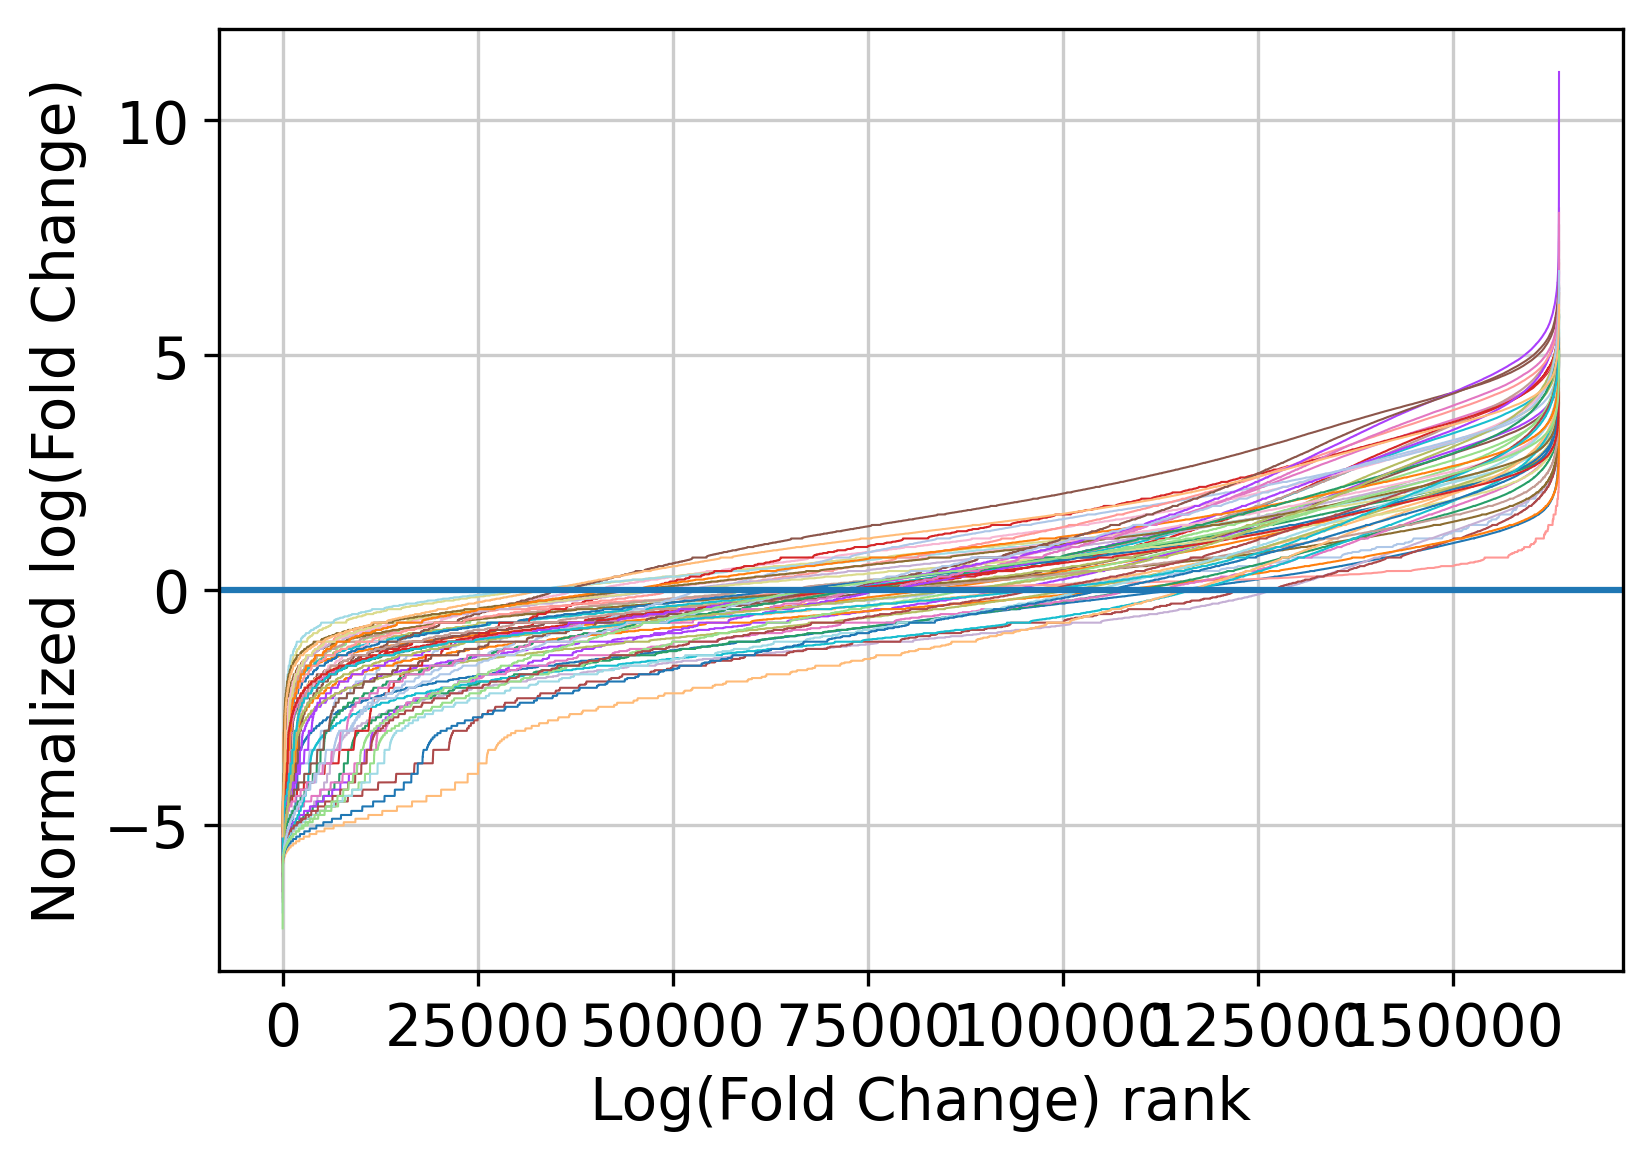

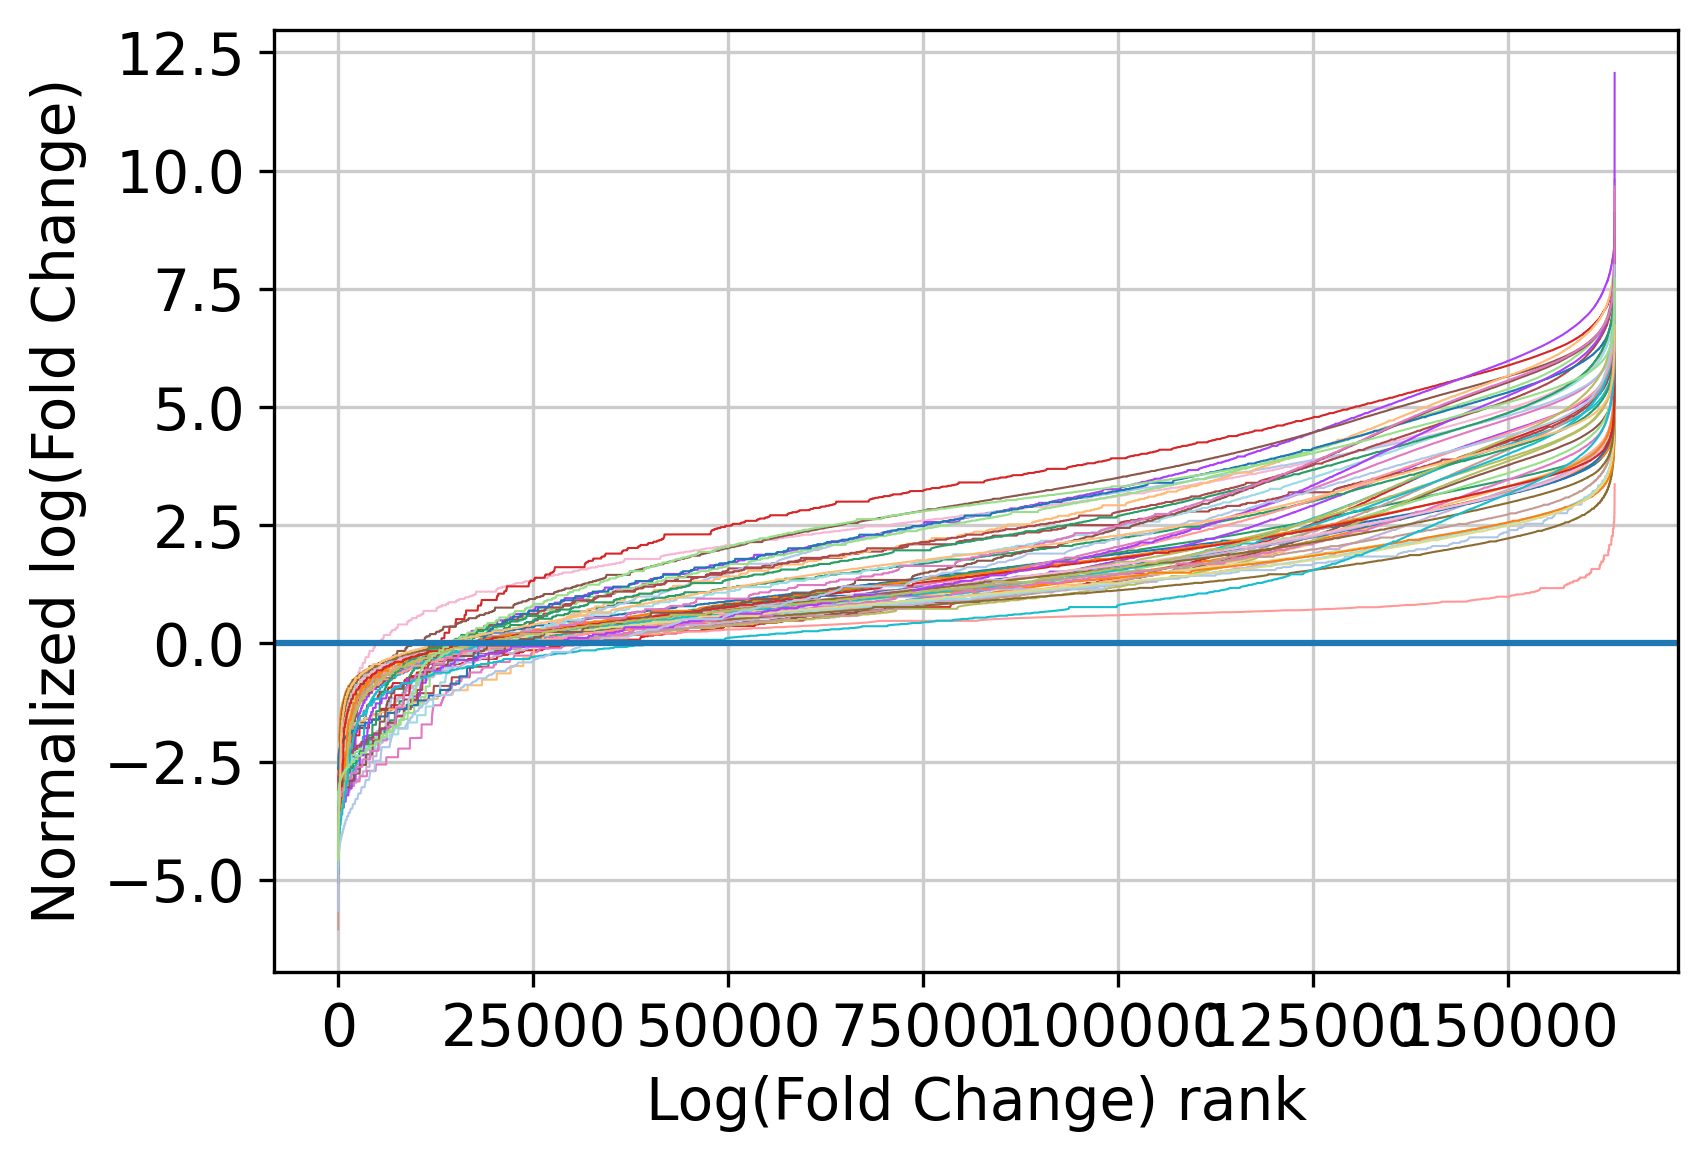

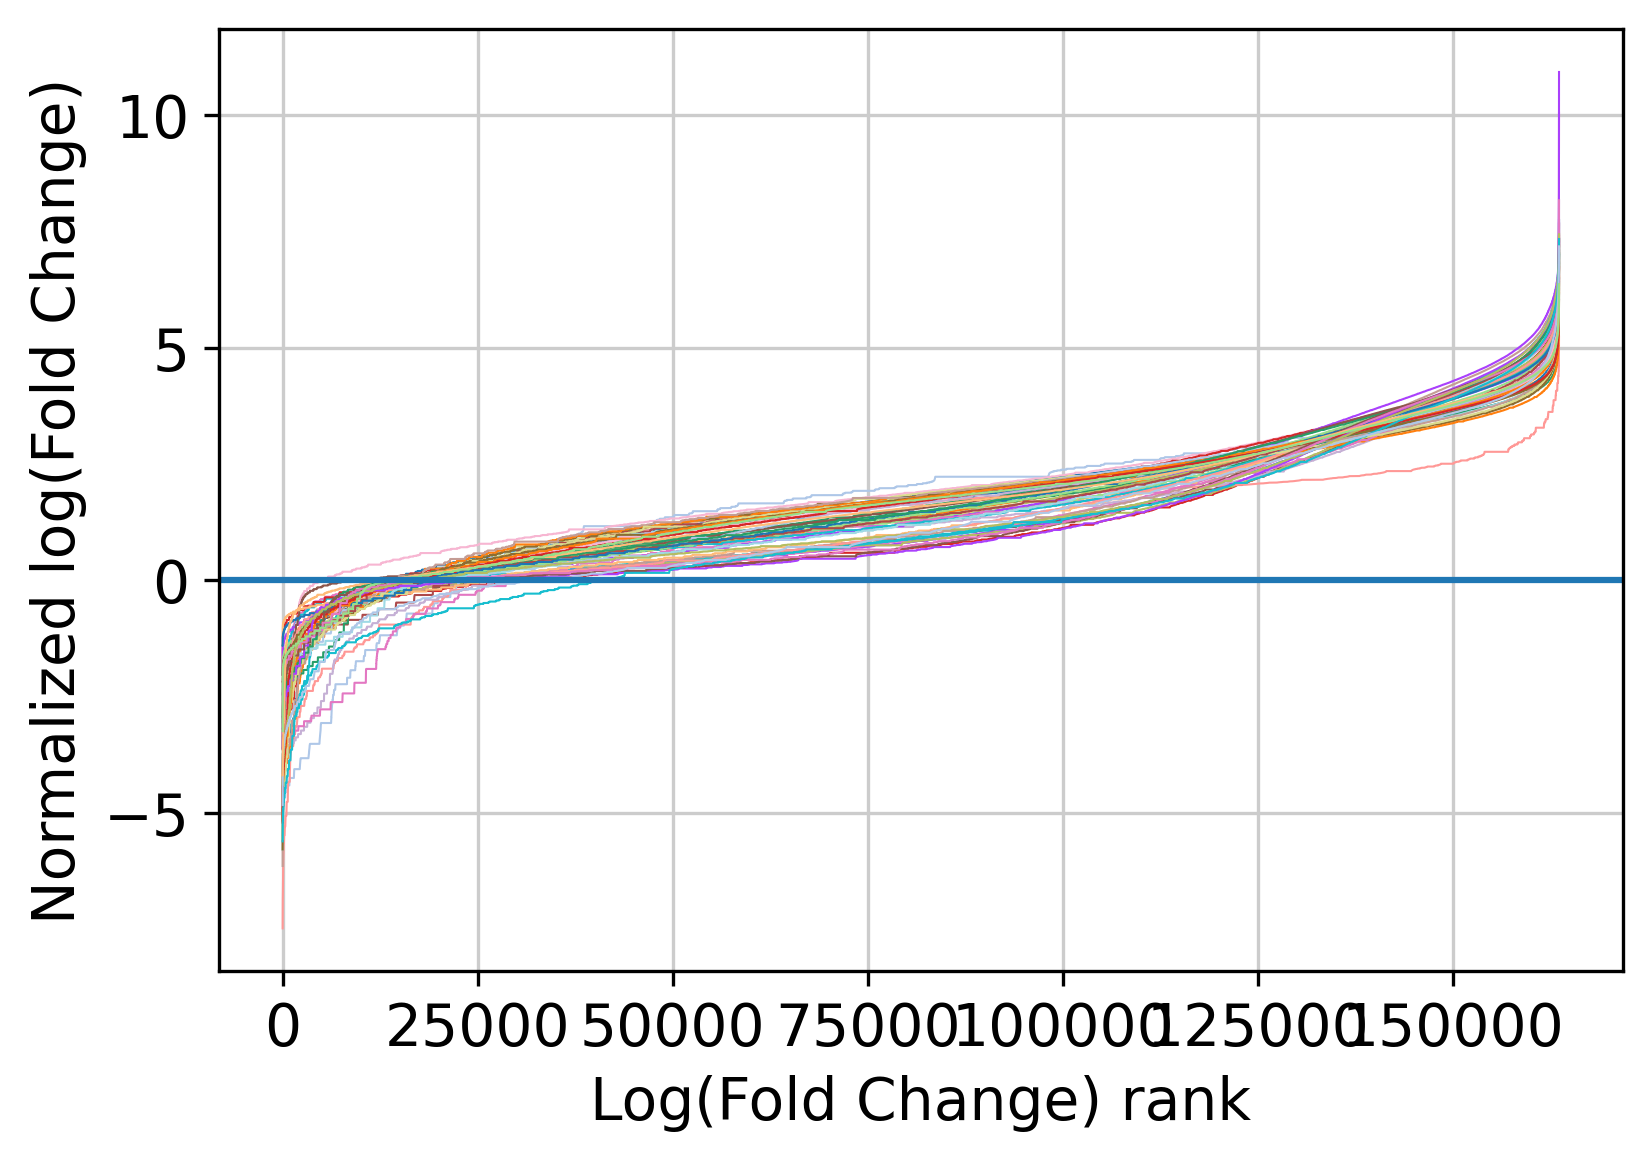

(52, 1)
ENCFF499NSJ.bam     8.106884
ENCFF006DTI.bam     7.274490
ENCFF569BNQ.bam    10.730376
ENCFF642LZZ.bam    17.342016
ENCFF135PWQ.bam    21.784329
ENCFF208VCM.bam    12.230853
ENCFF234GSL.bam    26.268808
ENCFF213VRU.bam    11.557292
ENCFF661HCG.bam    16.243500
ENCFF365AYG.bam     3.092001
ENCFF558XUB.bam     7.692400
ENCFF126SQQ.bam     9.553713
ENCFF660SOQ.bam     1.787877
ENCFF489WEK.bam     8.100775
ENCFF316MYK.bam    10.732399
ENCFF131QPU.bam    30.012154
ENCFF087KRI.bam     4.591435
ENCFF587PBV.bam     4.211772
ENCFF792VGT.bam    19.928320
ENCFF728LMW.bam     3.324183
ENCFF537JAK.bam     7.309610
ENCFF108MOM.bam     5.041925
ENCFF449WLP.bam    18.429462
ENCFF931ZKM.bam    78.326033
ENCFF281BPR.bam    65.672528
ENCFF347FAA.bam    61.036927
ENCFF470HCZ.bam     9.374487
ENCFF850YUJ.bam    10.745034
ENCFF333HJE.bam    10.876488
ENCFF432RVZ.bam    35.405457
ENCFF769NQJ.bam    60.306345
ENCFF530KNQ.bam    47.834490
ENCFF583WYG.bam    19.830932
ENCFF325VPA.bam     7.094558
ENCFF7

In [9]:
print(dataset)
dataset = dataset.copy()
muffin.tools.rescale_input_center_scale(dataset, plot=True)
design = np.concatenate([np.ones((len(dataset),1))], axis=1)
print(design.shape)
muffin.load.set_design_matrix(dataset, design)
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]
print(dataset.obs["pi0"])

The next step is to fit the mean-variance relationship and the compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 248 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:   22.2s
[Parallel(n_jobs=16)]: Done 86048 tasks      | elapsed:   55.0s
[Parallel(n_jobs=16)]: Done 161266 tasks      | elapsed:  1.4min
[Parallel(n_jobs=16)]: Done 163624 out of 163624 | elapsed:  1.4min finished
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


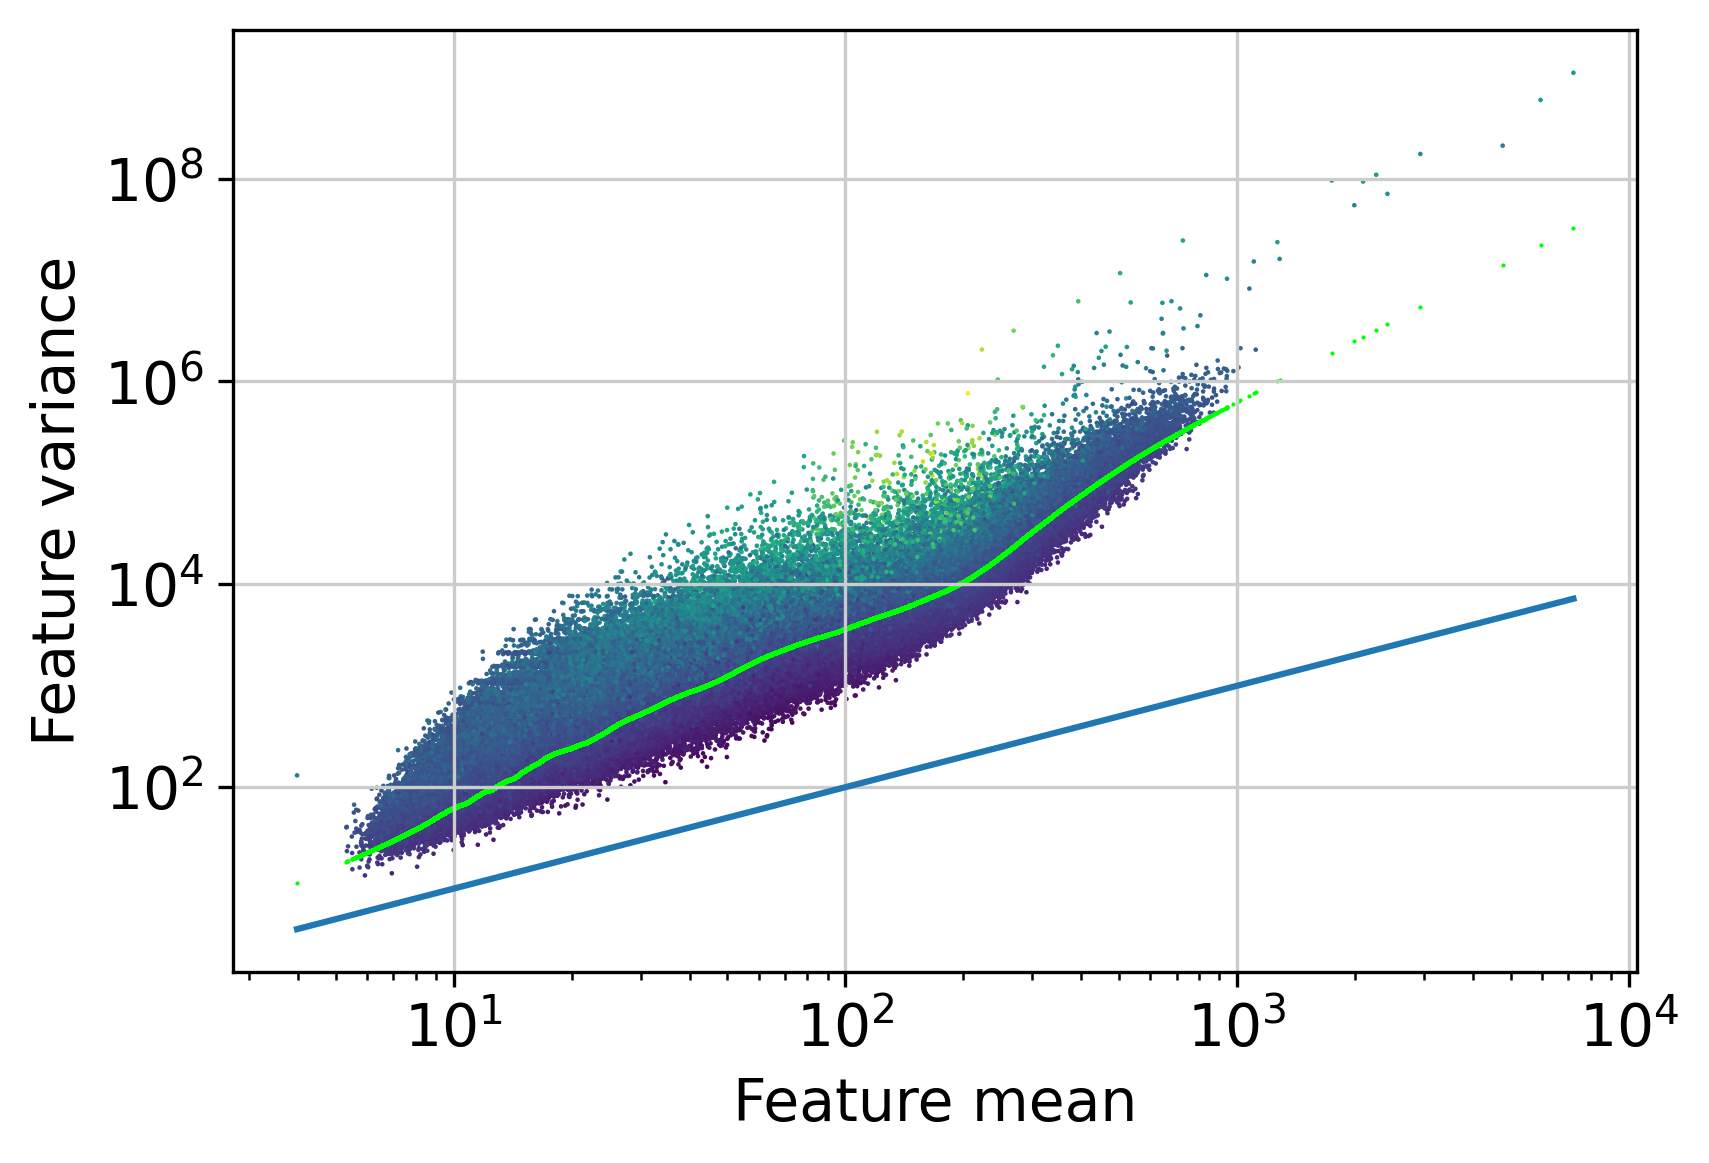

AnnData object with n_obs × n_vars = 52 × 163624
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    obsm: 'design'
    layers: 'input', 'normalization_factors', 'residuals'

In [10]:
muffin.tools.compute_residuals(dataset, maxThreads=16)

We can perform feature selection to remove peaks with low information. Additionally for ChIP-seq we propose a tool to remove features with insufficient enrichment over input, which can be useful if you use a large catalogue of regions without peak calling. As peak calling was already performed, almost all features are passing this step.

<Figure size 1800x1200 with 0 Axes>

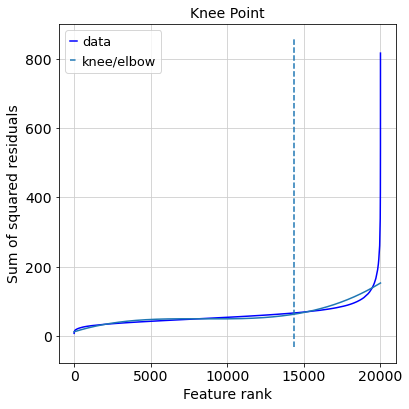

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


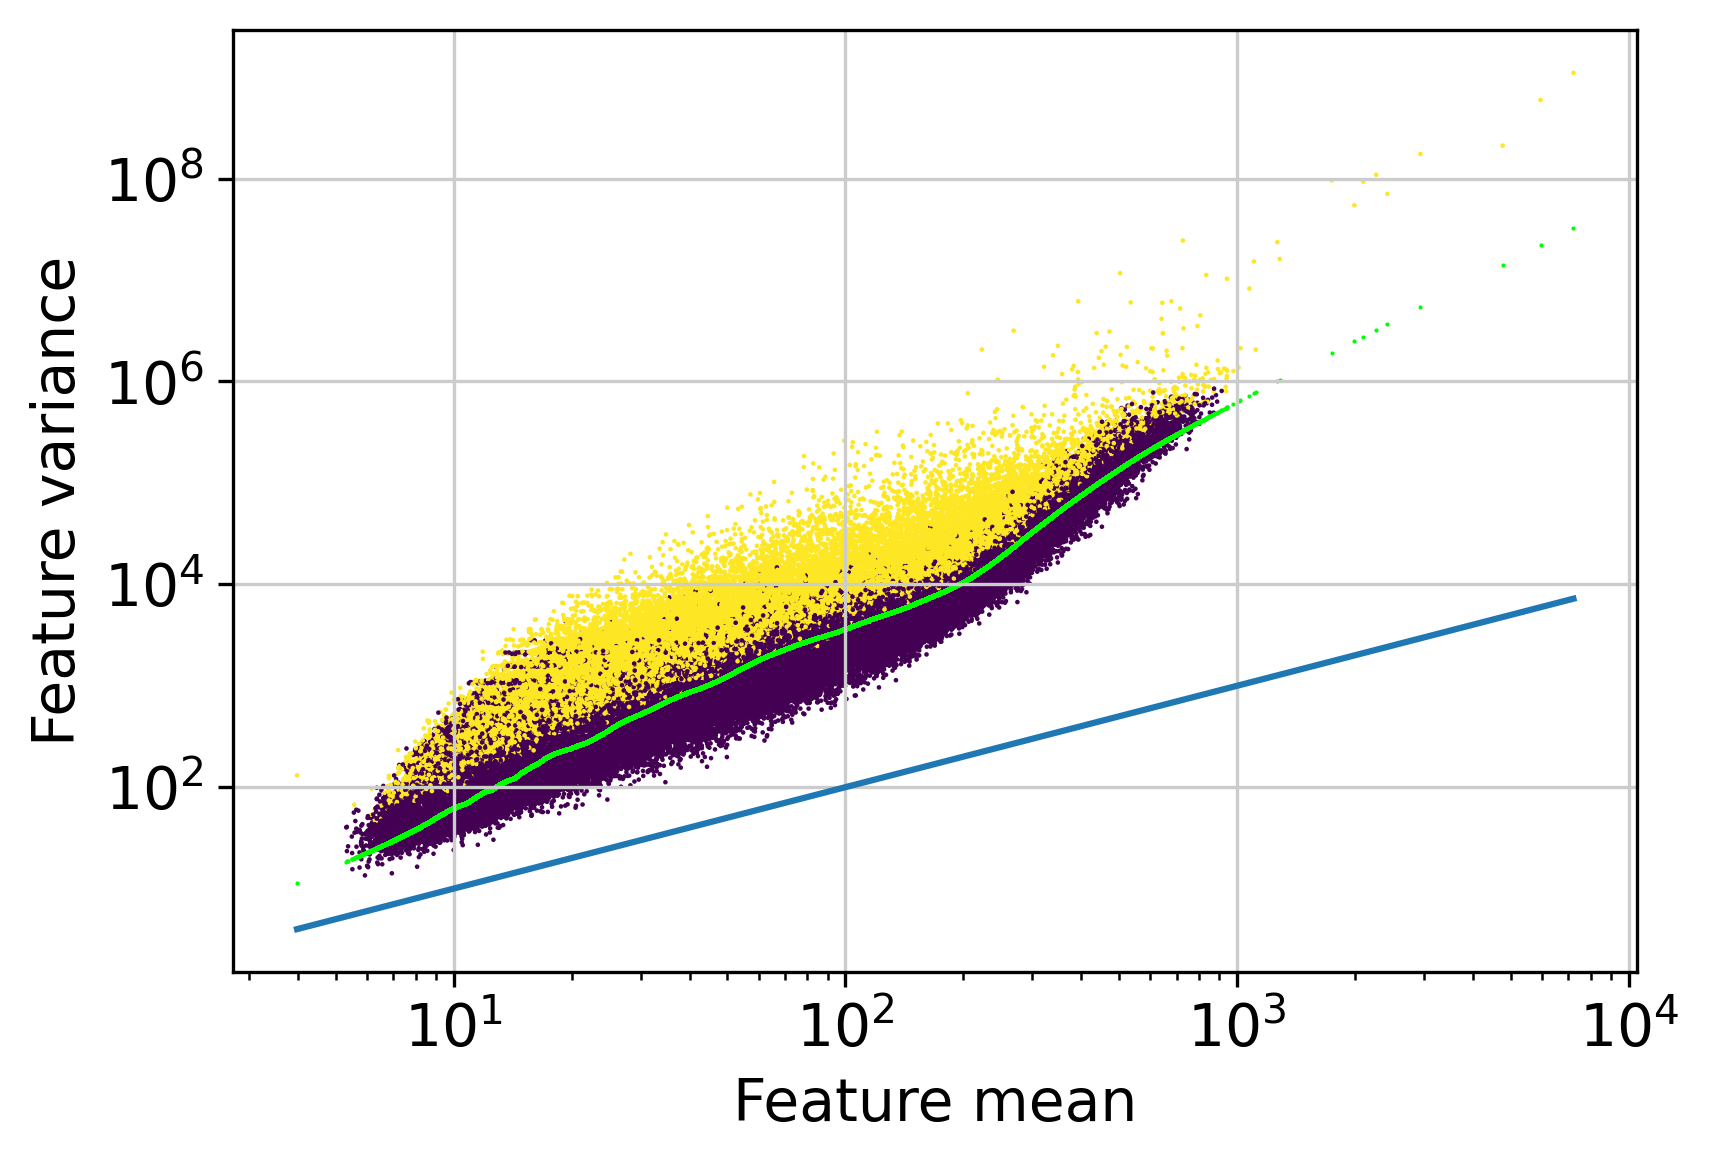

0.9999938884271256


In [11]:
peaks = muffin.tools.pseudo_peak_calling(dataset)
hv = muffin.tools.feature_selection_elbow(dataset)
print(np.mean(peaks))

Next, we perform dimensionnality reduction through with PCA and UMAP.

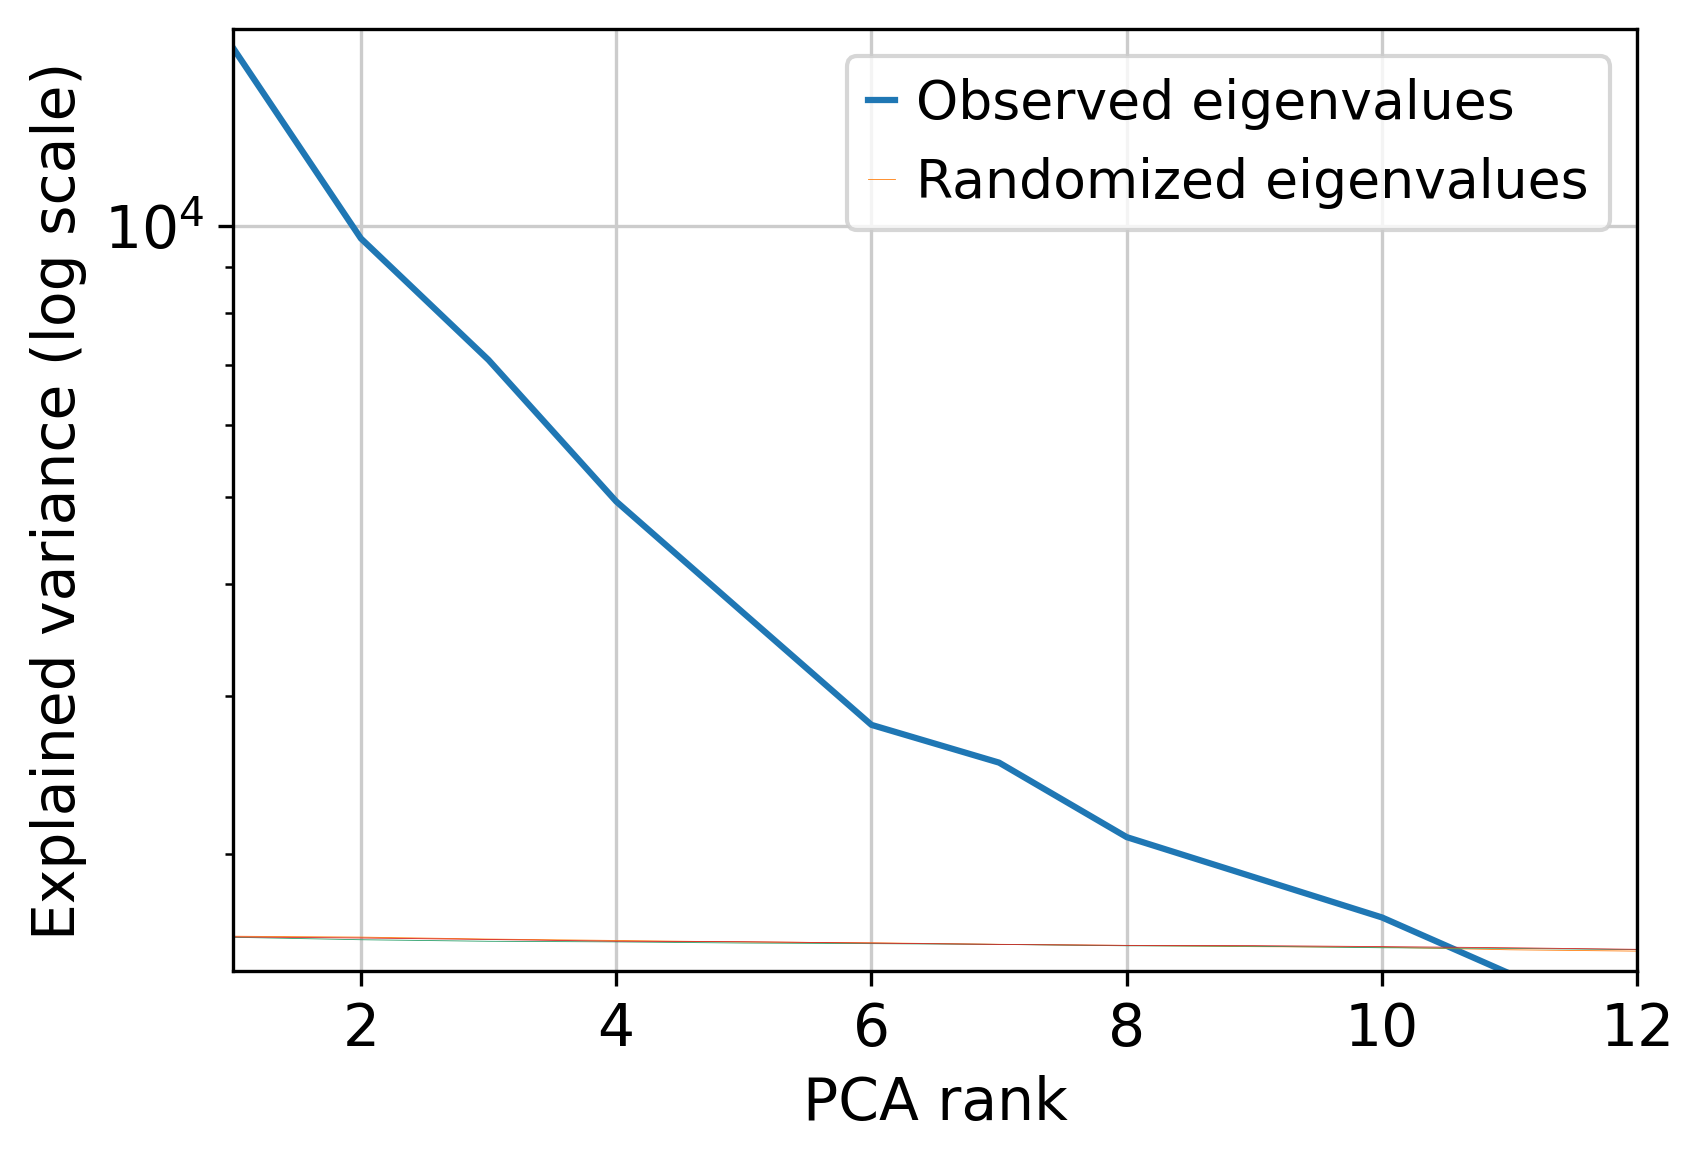

AnnData object with n_obs × n_vars = 52 × 163624
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random', 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'input', 'normalization_factors', 'residuals'

In [12]:
muffin.tools.compute_pa_pca(dataset, feature_mask=peaks&hv, plot=True)
muffin.tools.compute_umap(dataset)

Display the results. Note that we can use scanpy functions here!

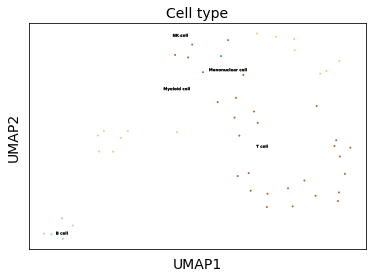

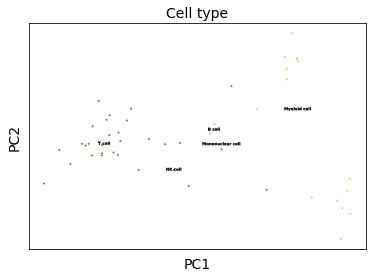

In [13]:
# Append cell type info to the dataset
dataset.obs["Cell type detailed"] = metadata_chip["Biosample term name"].values
dataset.obs["Cell type"] = metadata_chip["Biosample cell type"].values
sc.pl.umap(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')
sc.pl.pca(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')

We can also use heatmaps, even if we have a large number of features :

46144


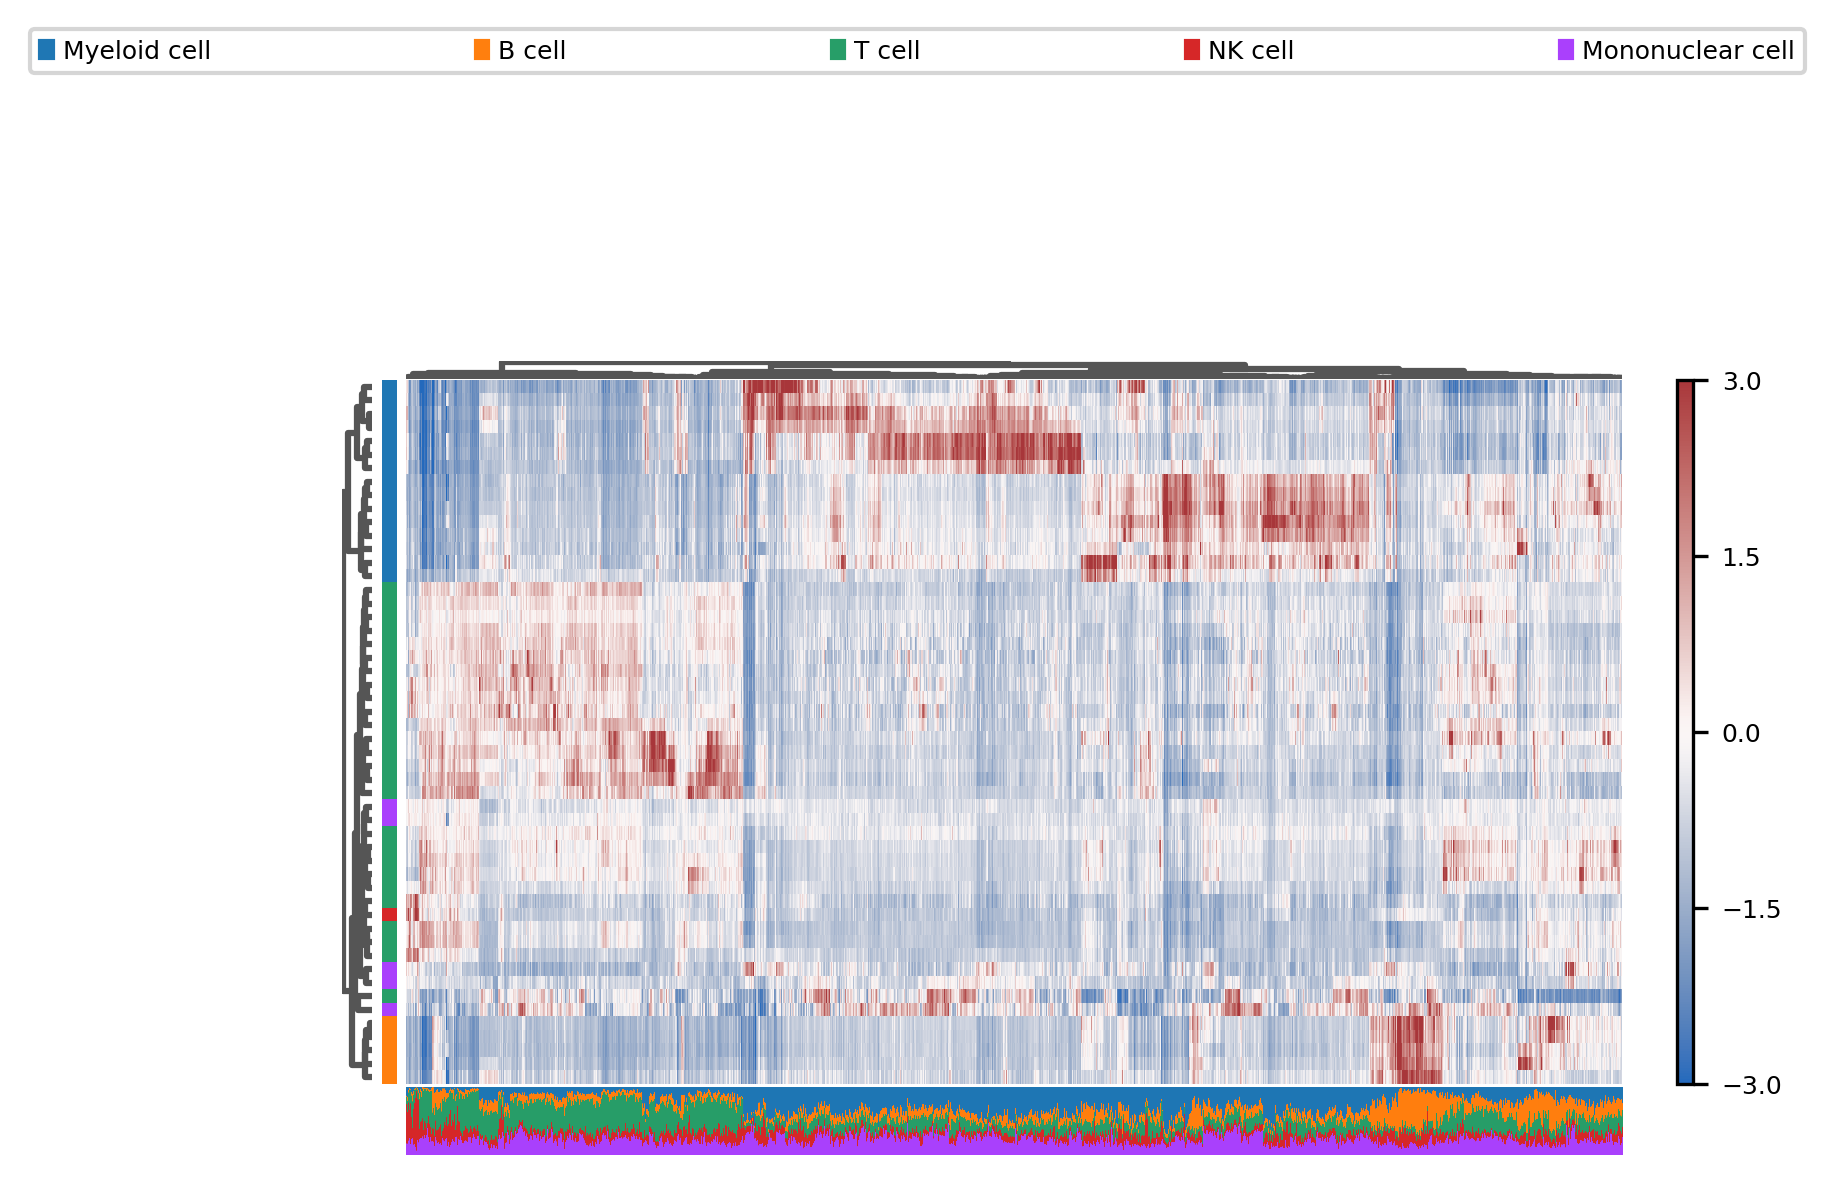

In [22]:
print((peaks & hv).sum())
fig, ax = muffin.plots.mega_heatmap(dataset[:, peaks & hv], layer="residuals", label_col="Cell type", vmin=-3, vmax=3)

Let's find the differentially bound regions between T-cells and B-cells:

In [15]:
# First subset our dataset
selected = dataset[(dataset.obs["Cell type"] == "B cell") | (dataset.obs["Cell type"] == "T cell")]
muffin.tools.differential_expression_A_vs_B(selected, category="Cell type", 
                                        ref_category="T cell")


Comparing B cell to (reference) T cell
Using DESeq2 with normalization factors per row, per gene


R[write to console]: converting counts to integer mode

R[write to console]: using pre-existing normalization factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1442 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



Let's have a first look at the best markers between B and T cells :

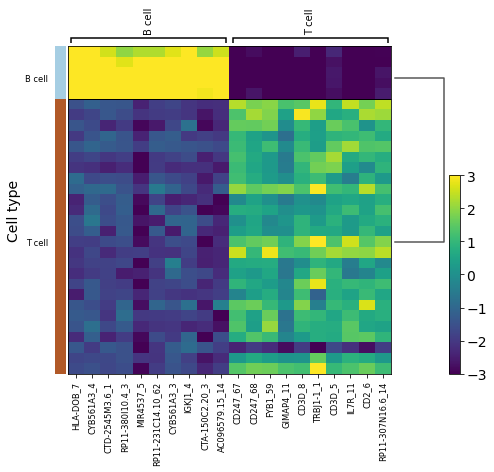

,z-score,log2FoldChange,pvalue,padj
HLA-DOB_7,15.302674,5.088282,7.337924e-53,1.100769e-47
CYB561A3_4,14.518801,4.745618,9.210675e-48,6.908513e-43
CTD-2545M3.6_1,14.475394,4.847525,1.733287e-47,8.667071e-43
MIR4537_5,14.221296,5.427724,6.758923e-46,2.027826e-41
RP11-380I10.4_3,14.234765,4.651491,5.575039e-46,2.027826e-41
...,...,...,...,...
GLYATL1_3,-0.062054,-0.023450,9.505201e-01,1.000000e+00
GLYATL2_4,0.011781,0.023025,9.906005e-01,1.000000e+00
GLYATL2_3,0.811865,0.319651,4.168689e-01,1.000000e+00
GLYATL2_2,0.145809,0.052990,8.840719e-01,1.000000e+00


In [16]:
sc.pl.rank_genes_groups_heatmap(selected,layer="residuals", 
                                use_raw=False, vmin=-3, vmax=3, 
                                cmap='viridis')
selected.varm["DE_results"].sort_values("padj")


We can already see genes specific to T cells (CD3E, CD3D...) and some specific to B cells (BLNK, BLK...). We can go further and perform a Genomic Regions Enrichment Analysis to get a GSEA of nearby genes.

In [17]:
# Retrieve DE regions
DE_indexes = (selected.varm["DE_results"]["padj"] < 0.05) & (np.abs(selected.varm["DE_results"]["log2FoldChange"]) > 1.0)
all_regions = selected.var[["Chromosome", "Start", "End"]]
query = all_regions[DE_indexes]
# Perform GREA
gsea_results = gsea_obj.find_enriched(query, all_regions, cores=16)
gsea_results

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 2624 tasks      | elapsed:  2.5min
[Parallel(n_jobs=16)]: Done 8504 tasks      | elapsed:  5.4min
[Parallel(n_jobs=16)]: Done 9170 out of 9170 | elapsed:  5.9min finished


,P(Beta > 0),Beta,BH corrected p-value,-log10(qval),-log10(pval),FC,Name,Total hits
0,,,,,,,,
GO:0002250,2.345892e-48,0.585885,2.151183e-44,4.366732e+01,4.762969e+01,1.796580,adaptive immune response,2939
GO:0046649,5.110348e-17,0.288325,2.343095e-13,1.263021e+01,1.629155e+01,1.334190,lymphocyte activation,4061
GO:0002684,7.162489e-16,0.254110,1.978139e-12,1.170374e+01,1.514494e+01,1.289313,positive regulation of immune system process,4251
GO:0050851,8.628743e-16,0.521975,1.978139e-12,1.170374e+01,1.506405e+01,1.685352,antigen receptor-mediated signaling pathway,1382
GO:0045321,1.152480e-15,0.254527,2.113649e-12,1.167497e+01,1.493837e+01,1.289851,leukocyte activation,4509
...,...,...,...,...,...,...,...,...
GO:0019752,9.999925e-01,-0.177232,9.999999e-01,3.190078e-08,3.263525e-06,0.837586,carboxylic acid metabolic process,1404
GO:0007098,9.999960e-01,-0.515354,9.999999e-01,3.190078e-08,1.726051e-06,0.597289,centrosome cycle,130
GO:0007017,9.999976e-01,-0.185194,9.999999e-01,3.190078e-08,1.023852e-06,0.830943,microtubule-based process,1338


We do observe an enrichment of immune and T/B Cells related terms.

In [24]:
import plotly.offline as pyo
gsea_obj.cluster_treemap(gsea_results)

,P(Beta > 0),Beta,BH corrected p-value,-log10(qval),-log10(pval),FC,Name,Total hits,Cluster,Representative
0,,,,,,,,,,
GO:0046649,5.110348e-17,0.288325,2.343095e-13,12.630210,16.291549,1.334190,Lymphocyte<br>activation,4061,0,
GO:0045321,1.152480e-15,0.254527,2.113649e-12,11.674967,14.938367,1.289851,Leukocyte<br>activation,4509,0,Lymphocyte<br>activation
GO:0002696,5.522070e-13,0.344569,4.603399e-10,9.336921,12.257898,1.411381,Positive<br>regulation of<br>leukocyte<br>acti...,2096,0,Lymphocyte<br>activation
GO:0050867,6.506131e-13,0.338011,4.954420e-10,9.305007,12.186677,1.402156,Positive<br>regulation of<br>cell activation,2128,0,Lymphocyte<br>activation
GO:0051251,7.074394e-13,0.362142,4.954420e-10,9.305007,12.150311,1.436403,Positive<br>regulation of<br>lymphocyte<br>act...,1938,0,Lymphocyte<br>activation
...,...,...,...,...,...,...,...,...,...,...
GO:0002312,8.631356e-05,0.377115,7.195412e-03,2.142944,4.063921,1.458072,B cell<br>activation<br>involved in<br>immune ...,537,9,B cell mediated<br>immunity
GO:0002520,1.968684e-04,0.236931,1.399444e-02,1.854044,3.705824,1.267354,Immune system<br>development,1164,9,B cell mediated<br>immunity
GO:0002200,2.681538e-04,0.366380,1.769043e-02,1.752262,3.571616,1.442503,Somatic<br>diversification<br>of immune<br>rec...,489,9,B cell mediated<br>immunity


We can save our work to avoid recomputing everything. It can easily be re-loaded using :  anndata.read_h5ad(path)

In [19]:
dataset.write("h3k4me3_results/dataset.h5ad")